In [1]:
import os
import json
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
def load_json_data(
        data_directories:list
        ):
        reservoir_dynamics = []
        entangled_labels = []

        if type(data_directories) is list:
                for directory in data_directories:
                        for filename in os.listdir(directory):
                                if filename.endswith('.json'):
                                        filepath = os.path.join(directory, filename)
                                        with open(filepath, 'r') as file:
                                                json_data = json.load(file)
                                                reservoir_dynamics.append(json_data['reservoir_dynamics'])
                                                entangled_labels.append(json_data['entangled_label'])
        elif type(data_directories) is str:
                for filename in os.listdir(data_directories):
                                if filename.endswith('.json'):
                                        filepath = os.path.join(data_directories, filename)
                                        with open(filepath, 'r') as file:
                                                json_data = json.load(file)
                                                reservoir_dynamics.append(json_data['reservoir_dynamics'])
                                                entangled_labels.append(json_data['entangled_label'])
        
        return np.array(reservoir_dynamics), np.array(entangled_labels)


def generate_xgb_cv_scores(
                reservoir_dynamics:list,
                entangled_labels:list,
                n_datapoints_sample:int,
                xgb_hyperparameters:dict,
                n_timepoints:int=20,
                cv_number:int=10,
    ):
        if len(reservoir_dynamics) < n_datapoints_sample:
                raise ValueError("Sample size cannot be larger than dataset")
        elif len(reservoir_dynamics) == n_datapoints_sample:
                pass
        else:
                random_indices = np.random.choice(len(reservoir_dynamics), n_datapoints_sample, replace=False)
                reservoir_dynamics = reservoir_dynamics[random_indices]
                entangled_labels = entangled_labels[random_indices]

        n_datapoints = reservoir_dynamics.shape[0]
        n_reservoir_qubits = reservoir_dynamics.shape[1]
        
        # Calculate the indices to access from the original array based on time spacing 
        time_sample_indices = np.linspace(0, n_reservoir_qubits - 1, n_timepoints, dtype=int)
        sampled_reservoir_dynamics = reservoir_dynamics[:, :, time_sample_indices]

        # Flatten the training data column-wise
        transponsed_sampled_reservoir_dynamics = sampled_reservoir_dynamics.transpose(0, 2, 1)  

        # Flatten to (n_datapoints, n_features)
        reservoir_dynamics_flattened = transponsed_sampled_reservoir_dynamics.reshape(n_datapoints, -1)

        XGB_classifier = XGBClassifier(**xgb_hyperparameters)
        cv_scores = cross_val_score(XGB_classifier, reservoir_dynamics_flattened, entangled_labels, cv=cv_number)

        return cv_scores


def generate_xgb_train_test_accuracy_ratio(
                reservoir_dynamics:list,
                entangled_labels:list,
                n_datapoints_sample:int,
                xgb_hyperparameters:dict,
                test_size:float=0.2,
                n_timepoints:int=20,
    ):
        if len(reservoir_dynamics) < n_datapoints_sample:
                raise ValueError("Sample size cannot be larger than dataset")
        elif len(reservoir_dynamics) == n_datapoints_sample:
                pass
        else:
                random_indices = np.random.choice(len(reservoir_dynamics), n_datapoints_sample, replace=False)
                reservoir_dynamics = reservoir_dynamics[random_indices]
                entangled_labels = entangled_labels[random_indices]

        n_datapoints = reservoir_dynamics.shape[0]
        n_reservoir_qubits = reservoir_dynamics.shape[1]
        
        # Calculate the indices to access from the original array based on time spacing 
        time_sample_indices = np.linspace(0, n_reservoir_qubits - 1, n_timepoints, dtype=int)
        sampled_reservoir_dynamics = reservoir_dynamics[:, :, time_sample_indices]

        # Flatten the training data column-wise
        transponsed_sampled_reservoir_dynamics = sampled_reservoir_dynamics.transpose(0, 2, 1)  

        # Flatten to (n_datapoints, n_features)
        reservoir_dynamics_flattened = transponsed_sampled_reservoir_dynamics.reshape(n_datapoints, -1)

        # Train the classifier
        XGB_classifier = XGBClassifier(**xgb_hyperparameters)

        X_train, X_test, y_train, y_test = train_test_split(reservoir_dynamics_flattened, entangled_labels, test_size=test_size, random_state=42, shuffle=True)

        XGB_classifier.fit(X_train, y_train)

        y_pred_train = XGB_classifier.predict(X_train)
        y_pred = XGB_classifier.predict(X_test)

        train_accuracy = accuracy_score(y_train, y_pred_train)
        accuracy = accuracy_score(y_test, y_pred)

        test_train_accuracy = accuracy / train_accuracy

        return test_train_accuracy

# Data Load & Model Params

In [3]:
five_qubit_reservoir_dynmaics, five_qubit_entangled_labels = load_json_data('data/experiment_run_2')
six_qubit_reservoir_dynmaics, six_qubit_entangled_labels = load_json_data(['data/6_qubit_reservoir', 'data/6_qubit_reservoir_2'])

In [4]:
xgb_hyperparameters= {"learning_rate":0.01, "max_depth":3, "n_estimators":200, "subsample":0.8, "colsample_bytree":0.8}

In [5]:
NUMBER_OF_CROSS_FOLDS = 5

# Reservoir Comparison Size

In [6]:
dataset_sample_sizes = np.linspace(500, six_qubit_reservoir_dynmaics.shape[0], 10, dtype=int)

In [7]:
dataset_sample_sizes

array([ 500,  710,  920, 1130, 1340, 1550, 1760, 1970, 2180, 2390])

In [8]:
five_qubit_cv_scores = []
six_qubit_cv_scores = []
five_test_train_accuracies = []
six_test_train_accuracies = []
for sample_size in dataset_sample_sizes:
    current_5_cv_score = generate_xgb_cv_scores(
        five_qubit_reservoir_dynmaics,
        five_qubit_entangled_labels,
        sample_size,
        xgb_hyperparameters,
        cv_number=NUMBER_OF_CROSS_FOLDS
    )
    five_qubit_cv_scores.append(current_5_cv_score)
    
    current_5_test_train_accuracy = generate_xgb_train_test_accuracy_ratio(
        five_qubit_reservoir_dynmaics,
        five_qubit_entangled_labels,
        sample_size,
        xgb_hyperparameters,
    )
    five_test_train_accuracies.append(current_5_test_train_accuracy)

    current_6_cv_score = generate_xgb_cv_scores(
        six_qubit_reservoir_dynmaics,
        six_qubit_entangled_labels,
        sample_size,
        xgb_hyperparameters,
    )
    six_qubit_cv_scores.append(current_6_cv_score)

    current_6_test_train_accuracy = generate_xgb_train_test_accuracy_ratio(
        six_qubit_reservoir_dynmaics,
        six_qubit_entangled_labels,
        sample_size,
        xgb_hyperparameters,
    )
    six_test_train_accuracies.append(current_6_test_train_accuracy)

In [9]:
# Find means and stds
five_qubit_cv_means = [np.mean(scores) for scores in five_qubit_cv_scores]
five_qubit_cv_std = [np.std(scores)/np.sqrt(NUMBER_OF_CROSS_FOLDS) for scores in five_qubit_cv_scores]
six_qubit_cv_means = [np.mean(scores) for scores in six_qubit_cv_scores]
six_qubit_cv_std = [np.std(scores)/np.sqrt(NUMBER_OF_CROSS_FOLDS) for scores in six_qubit_cv_scores]

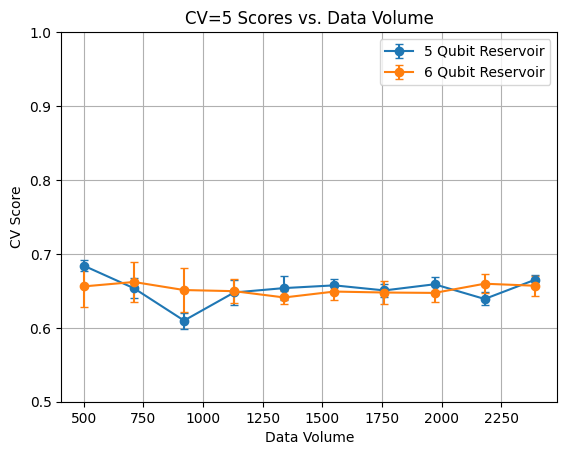

In [10]:
plt.errorbar(dataset_sample_sizes, five_qubit_cv_means, yerr=five_qubit_cv_std, fmt='o-', capsize=3, label='5 Qubit Reservoir')
plt.errorbar(dataset_sample_sizes, six_qubit_cv_means, yerr=six_qubit_cv_std, fmt='o-', capsize=3, label='6 Qubit Reservoir')
plt.xlabel('Data Volume')
plt.ylabel('CV Score')
plt.ylim([0.5, 1])
plt.title(f'CV={NUMBER_OF_CROSS_FOLDS} Scores vs. Data Volume')
plt.grid(True)
plt.legend()
plt.show()

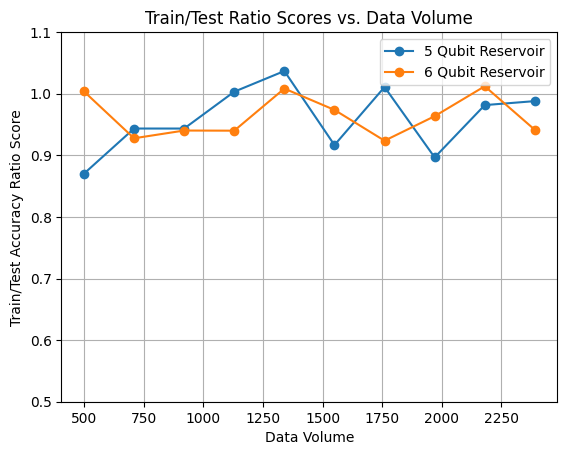

In [11]:
plt.plot(dataset_sample_sizes, five_test_train_accuracies, 'o-', label='5 Qubit Reservoir')
plt.plot(dataset_sample_sizes, six_test_train_accuracies, 'o-', label='6 Qubit Reservoir')
plt.xlabel('Data Volume')
plt.ylabel('Train/Test Accuracy Ratio Score')
plt.ylim([.5,1.1])
plt.title(f'Train/Test Ratio Scores vs. Data Volume')
plt.grid(True)
plt.legend()
plt.show()

## Full Data Volume Comparison for 5 Qubit

In [12]:
dataset_sample_sizes = np.linspace(500, five_qubit_reservoir_dynmaics.shape[0], 10, dtype=int)

In [13]:
dataset_sample_sizes

array([  500,  1555,  2611,  3666,  4722,  5777,  6833,  7888,  8944,
       10000])

In [14]:
five_qubit_cv_scores = []
five_test_train_accuracies = []
for sample_size in dataset_sample_sizes:
    current_5_cv_score = generate_xgb_cv_scores(
        five_qubit_reservoir_dynmaics,
        five_qubit_entangled_labels,
        sample_size,
        xgb_hyperparameters,
    )
    five_qubit_cv_scores.append(current_5_cv_score)

    current_5_test_train_accuracy = generate_xgb_train_test_accuracy_ratio(
        five_qubit_reservoir_dynmaics,
        five_qubit_entangled_labels,
        sample_size,
        xgb_hyperparameters,
    )
    five_test_train_accuracies.append(current_5_test_train_accuracy)

In [15]:
# Find means and stds
five_qubit_cv_means = [np.mean(scores) for scores in five_qubit_cv_scores]
five_qubit_cv_std = [np.std(scores)/np.sqrt(NUMBER_OF_CROSS_FOLDS) for scores in five_qubit_cv_scores]

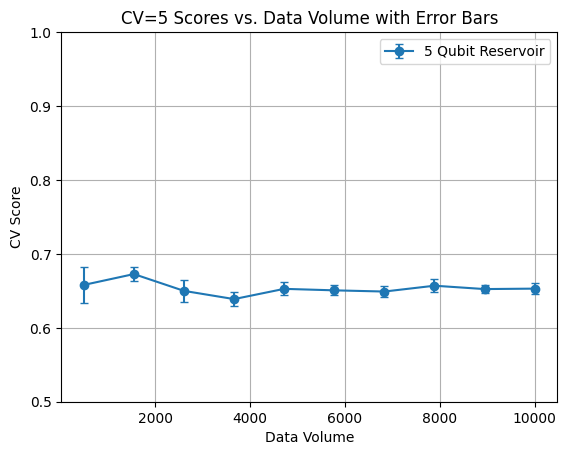

In [16]:
plt.errorbar(dataset_sample_sizes, five_qubit_cv_means, yerr=five_qubit_cv_std, fmt='o-', capsize=3, label='5 Qubit Reservoir')
plt.xlabel('Data Volume')
plt.ylabel('CV Score')
plt.ylim([0.5, 1])
plt.title(f'CV={NUMBER_OF_CROSS_FOLDS} Scores vs. Data Volume with Error Bars')
plt.grid(True)
plt.legend()
plt.show()

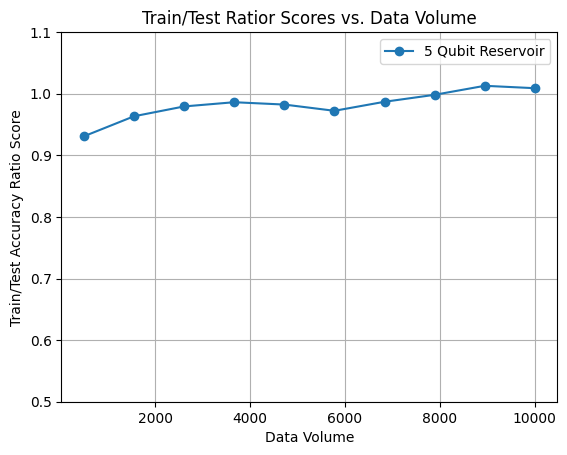

In [17]:
plt.plot(dataset_sample_sizes, five_test_train_accuracies, 'o-', label='5 Qubit Reservoir')
plt.xlabel('Data Volume')
plt.ylabel('Train/Test Accuracy Ratio Score')
plt.ylim([.5,1.1])
plt.title(f'Train/Test Ratior Scores vs. Data Volume')
plt.grid(True)
plt.legend()
plt.show()